# Simple Random Forest Calssifer Template
Goal of this notebook is to avoid rewrinting code for Random Forest with tabular data


In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from pickle import dump,load



# Prepare The dataset

In [ ]:
# Use a random df instead of df = pd.read_csv(""), it is just a template
df = pd.DataFrame(np.random.randint(0,100,size=(1000, 6)), columns=["f1","f2","f3","f4","f5","f6",])
df["y"] = np.random.randint(0,8,size=(1000, 1))

df["y"].astype("category") # this is because it is a number, but have no real "number relationship", so we set is as a label 

# list of columns used as features and as target
features = ["f1","f2","f3","f4","f5","f6"]
target = ["y"]

df.head()


,f1,f2,f3,f4,f5,f6,y
0,30,35,27,58,70,96,6
1,89,62,54,86,41,52,3
2,64,44,22,57,99,3,6
3,61,35,82,0,85,89,1
4,72,74,46,21,96,23,1


In [ ]:
# if needed, spit the data into train\validation and test set
features_data = df[features].values
targets_data = df[target].values.ravel() #to pass from ( [sample,1] -> [[1],[2],[3])  to ([sample,] -> [1,2,3] )

# Split the dataset into training and temp sets (85% train, 15% temp)
features_train, features_test, targets_train, targets_test = train_test_split(
    features_data, targets_data, test_size=0.2, random_state=0
)


# Note that from now we are using numpy array of dimension (sample, features) 
print(f"Shape of the training feature set:\t {features_train.shape}")
print(f"Shape of the training target set:\t {targets_test.shape}")

Shape of the training feature set:	 (800, 6)
Shape of the training target set:	 (200,)


## Scaling

Scaling is important for traing: A feature with large values might artificially look more important, skewing learning.

Here the most common methods from sklearn: 
| Method         | Formula                  | Best For                        | Sensitive to Outliers |
|----------------|--------------------------|---------------------------------|-----------------------|
| StandardScaler | (x - μ) / σ             | General NN input, Gaussian data |  Yes                |
| MinMaxScaler   | (x - min) / (max - min) | Images, bounded features        |  Yes                |
| RobustScaler   | (x - median) / IQR      | Skewed data, outliers present   |  No                 |
| MaxAbsScaler   | x / max(abs(x))         | Sparse data, [-1,1] scaling     |  Yes                |

For sake of semplicity:

- Images → MinMax (0–1)
- General tabular → StandardScaler
- Outlier-heavy data → RobustScaler

In [20]:
scaler = StandardScaler()
# remember to fit only of training data
scaler.fit(features_train) 

# Transform the training, validation, and test sets
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

# Your Forest 

**Random Forest** is an ensemble machine learning method that builds **many decision trees** and combines their outputs.  
Each tree is trained on:
- a random subset of the data (rows) → *bootstrapping*
- a random subset of the features → *feature bagging*

For **classification**, the final prediction is made by **majority vote** among trees. This reduces overfitting and improves generalization compared to a single decision tree.



Key Hyperparameters to Know

| Parameter | Description | Typical Values / Notes |
|------------|--------------|------------------------|
| **`n_estimators`** | Number of trees in the forest | 100–500 is common (more → better, but slower) |
| **`max_depth`** | Maximum depth of each tree | `None` = grow fully; limit (e.g. 10–30) to prevent overfitting |
| **`min_samples_split`** | Minimum samples required to split a node | Increase to make trees more conservative |
| **`min_samples_leaf`** | Minimum samples required per leaf node | 1–5 typical; higher → smoother predictions |
| **`max_features`** | Number of features to consider per split | `"sqrt"` (default for classification), `"log2"`, or a fixed int/float |
| **`bootstrap`** | Whether to sample data with replacement | `True` (default) for standard Random Forest |
| **`n_jobs`** | Number of CPU cores to use | `-1` = all cores (for faster training) |


In [21]:
# Create and Fit the forest
rf_model = RandomForestClassifier(random_state=22)

rf_model.fit(features_train,targets_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
# Validate it 
y_pred = rf_model.predict(features_test)
rf_accuracy  = accuracy_score(targets_test,y_pred)

print(f"Accuracy:\t{rf_accuracy}")
print(f"\nClassification report:\n{classification_report(targets_test,y_pred)}")
print(f"\nConfusion Matrix:\n{confusion_matrix(targets_test,y_pred)}")


Accuracy:	0.125

Classification report:
              precision    recall  f1-score   support

           0       0.06      0.03      0.04        29
           1       0.12      0.17      0.14        18
           2       0.17      0.12      0.14        34
           3       0.17      0.10      0.12        20
           4       0.08      0.10      0.09        29
           5       0.18      0.30      0.23        23
           6       0.04      0.05      0.04        22
           7       0.17      0.16      0.16        25

    accuracy                           0.12       200
   macro avg       0.12      0.13      0.12       200
weighted avg       0.12      0.12      0.12       200


Confusion Matrix:
[[ 1  0  4  2  3 11  4  4]
 [ 3  3  2  1  4  2  2  1]
 [ 4  3  4  1  7  5  6  4]
 [ 1  4  2  2  5  2  3  1]
 [ 2  4  5  3  3  7  0  5]
 [ 1  1  1  1  7  7  4  1]
 [ 2  6  3  1  2  3  1  4]
 [ 2  3  3  1  7  2  3  4]]


## Let it Tune

We have different way to improve the performance of our model (exlunding features selection and data augmentation)

**KFold**

Implements **K-Fold Cross-Validation**: The dataset is divided into *k* equal parts (*folds*). The model is trained on *k−1* folds and validated on the remaining one.  
This process is repeated *k* times, each time using a different fold as validation.

- **Key Parameters:**
    - `n_splits` → number of folds (commonly 5 or 10)  
    - `shuffle` → whether to shuffle the data before splitting  
    - `random_state` → ensures reproducibility of the folds  

-  **Purpose:**  Provides a more **reliable estimate of model performance** by reducing variance due to a single train/test split.

**GridSearchCV**
Performs an **exhaustive search** over all combinations of specified hyperparameters using cross-validation.  
For each combination, the model is trained and validated, and the best set of hyperparameters is selected.

- **Key Parameters:**
    - `param_grid` → dictionary with hyperparameters and values to test  
    - `cv` → number of cross-validation folds  
    - `scoring` → metric used to evaluate model performance (e.g., `accuracy`, `f1`, `roc_auc`)  

**Purpose:** Finds the **optimal hyperparameters** by testing every possible combination.   Best for **small and discrete** hyperparameter spaces.


**RandomizedSearchCV**
Performs a **randomized search** over the hyperparameter space: instead of testing all combinations, it samples a fixed number of random configurations.

- **Key Parameters:**
    - `param_distributions` → dictionary with parameter ranges or statistical distributions  
    - `n_iter` → number of random parameter combinations to evaluate  
    - `cv` → number of cross-validation folds  
    - `scoring` → evaluation metric  
    - `random_state` → ensures reproducibility of sampled combinations  

- **Purpose:**   Provides a **faster alternative to Grid Search**, suitable for **large or continuous** hyperparameter spaces where exhaustive search is too expensive.



In [36]:
params_grid = {
    'n_estimators': [10,50,100],
    'max_depth': [3,5,20,None],
    'max_features': ['log2','sqrt',None],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False]
}

rf_model = RandomForestClassifier(random_state=22)

grid_search =  GridSearchCV(rf_model,params_grid,cv=5,n_jobs=-1,verbose=2)
grid_search.fit(features_train,targets_train)

rf_selected = grid_search.best_estimator_
print(f"best Pars:\t{grid_search.best_params_}")
print(f"best Score:\t{grid_search.best_score_}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
best Pars:	{'bootstrap': True, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 10}
best Score:	0.16874999999999998


In [ ]:
y_pred = rf_selected.predict(features_test)
rf_accuracy  = accuracy_score(targets_test,y_pred)

print(f"Accuracy:\t{rf_accuracy}")
print(f"\nClassification report:\n{classification_report(targets_test,y_pred)}")
print(f"\nConfusion Matrix:\n{confusion_matrix(targets_test,y_pred)}")

Accuracy:	0.15

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.10      0.14        29
           1       0.17      0.22      0.19        18
           2       0.13      0.06      0.08        34
           3       0.25      0.05      0.08        20
           4       0.09      0.10      0.10        29
           5       0.16      0.39      0.22        23
           6       0.17      0.14      0.15        22
           7       0.15      0.20      0.17        25

    accuracy                           0.15       200
   macro avg       0.17      0.16      0.14       200
weighted avg       0.16      0.15      0.14       200


Confusion Matrix:
[[ 3  2  0  1  5 10  3  5]
 [ 2  4  0  0  2  5  1  4]
 [ 4  4  2  0  7  7  2  8]
 [ 0  3  1  1  6  4  2  3]
 [ 2  3  3  2  3 10  3  3]
 [ 1  3  1  0  5  9  2  2]
 [ 2  3  2  0  2  6  3  4]
 [ 0  2  6  0  3  7  2  5]]


## Parameters Weight
After training a Random Forest model, you can access the attribute `feature_importances_` to understand **which features contribute most** to the model’s predictions

In [ ]:
features

['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

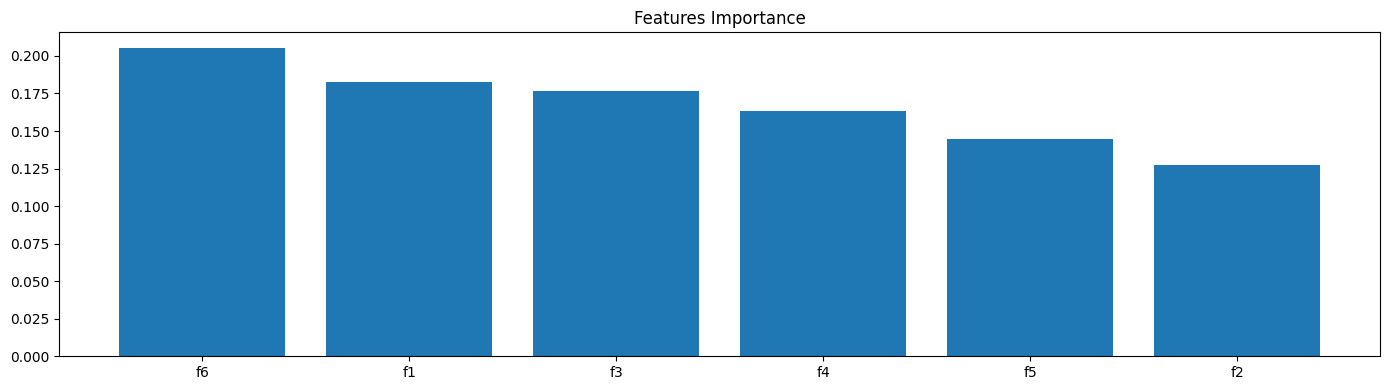

In [ ]:
# due to the fact that this is a random dataset, I expect a quite uniform distribution
fetures_importance = pd.Series(rf_selected.feature_importances_, features).sort_values(ascending=False)


plt.figure(figsize=(14,4))
plt.bar(fetures_importance.index,fetures_importance.values,align="center")
plt.title("Features Importance")
plt.tight_layout()

# Save and Load Models


To **save and reuse** trained models, scikit-learn supports several persistence formats:
- The most common approach is to use **Python’s serialization tools** such as `pickle` or `joblib` for storing and loading models.
- If the model needs to be used for **inference in other environments or languages**, formats like **ONNX** are also supported.

A complete list of supported methods and best practices is available in the official documentation: [Scikit-learn Model Persistence](https://scikit-learn.org/stable/model_persistence.html)


In [62]:
FILENAME = "random_forest"
with open(f"{FILENAME}.pkl", "wb") as f:
    dump(rf_selected, f, protocol=5)

In [ ]:
with open(f"{FILENAME}.pkl", "rb") as f:
    rf_model = load(f)

In [65]:
y_pred = rf_selected.predict(features_test)
rf_accuracy  = accuracy_score(targets_test,y_pred)

print(f"Accuracy Test:\t{rf_accuracy}")

Accuracy Test:	0.15
